# Data Preparation

The purpose of this notebook is to prepare data for machine learning models. It will use the data collected and it to fit the input and output of machine learning models. 

After running this notebook, the labels can be retrieved inside '/data' folder

In [1]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from data.helpers import *
import cv2
import random
import os
import numpy as np

## Data Augmention
To overcome the limitation of the AVFoundation framework, we collect our datasets in two formats. By combining HEIC and depth map grayscale into an RGBA image with depth-encoded alpha channel, we can extract more information about the colors, textures, and 3D geometry of objects in the scene, which can enhance the accuracy and robustness of the machine learning model for advanced classification tasks. Although thresholding techniques and contours mainly focus on the depth channel, in this research, we will also leverage the RGB channels to test the effectiveness of combining color and depth information in improving the performance of the model.

(768, 576, 4)


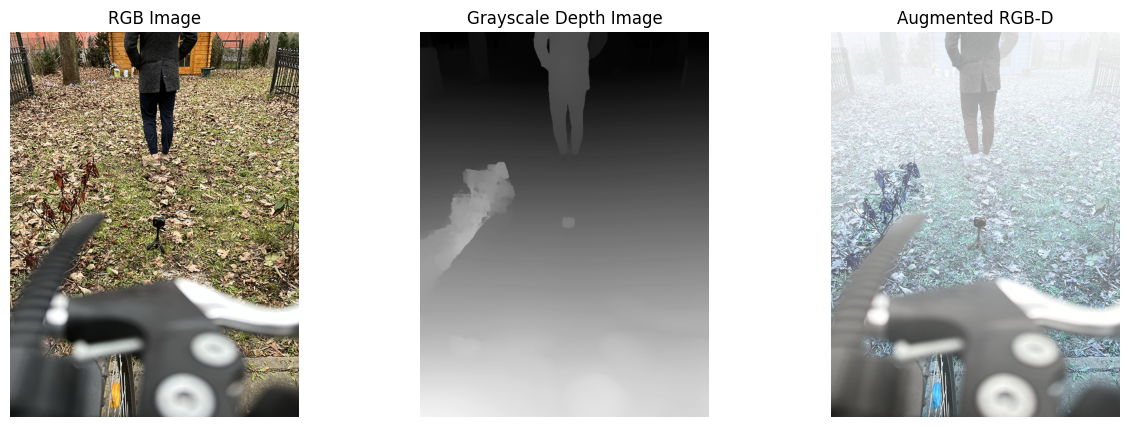

In [2]:
rgb_path = "data/test-images/ground_truth_rgb.png"
depth_path = "data/test-images/ground_truth_depth.png"
rgbd_path = "data/test-rgbd/ground_truth.png"

rgb_data = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
depth_data = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
height, width = depth_data.shape
rgb_data = cv2.resize(rgb_data, (width, height))
rgbd = np.dstack((rgb_data, depth_data))
rgbd = cv2.cvtColor(rgbd, cv2.COLOR_BGRA2RGBA)
cv2.imwrite(rgbd_path, rgbd)

#Load New RGB-D Image
read_rgbd_image = cv2.imread(rgbd_path, cv2.IMREAD_UNCHANGED)

#Make sure the image has 4 channels
rgbd_path_np = np.array(read_rgbd_image)
print(rgbd_path_np.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rgb_data)
ax[0].set_title('RGB Image')
ax[1].imshow(depth_data, cmap='gray')
ax[1].set_title('Grayscale Depth Image')
ax[2].imshow(read_rgbd_image)
ax[2].set_title('Augmented RGB-D')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()


## Image Sampling and Processing

This code applies the Nyquist criterion theorem to find the sampling rate or pixels per cycle based on the depth map of a ground truth image. Here's a step-by-step explanation of what the code is doing:

In [3]:
img = Image.open('data/test-rgbd/ground_truth.png')
img = np.array(img)

# Calculate Fourier transform of image
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

# Calculate magnitude spectrum of Fourier transform
magnitude_spectrum = 20*np.log(np.abs(fshift))
print("Magnitude spectrum shape: ", magnitude_spectrum.shape)

# Calculate spatial frequency of smallest detectable feature
f_min = 1 / np.max(img.shape)
print("Smallest detectable feature: ", f_min)

# Calculate Nyquist criterion
nyquist_rate = 2 * f_min
print("Nyquist criterion for image: ", nyquist_rate)

pixels_per_cycle = 1 / (2 * nyquist_rate)
print("Pixels per cycle: ", pixels_per_cycle)

Magnitude spectrum shape:  (768, 576, 4)
Smallest detectable feature:  0.0013020833333333333
Nyquist criterion for image:  0.0026041666666666665
Pixels per cycle:  192.0


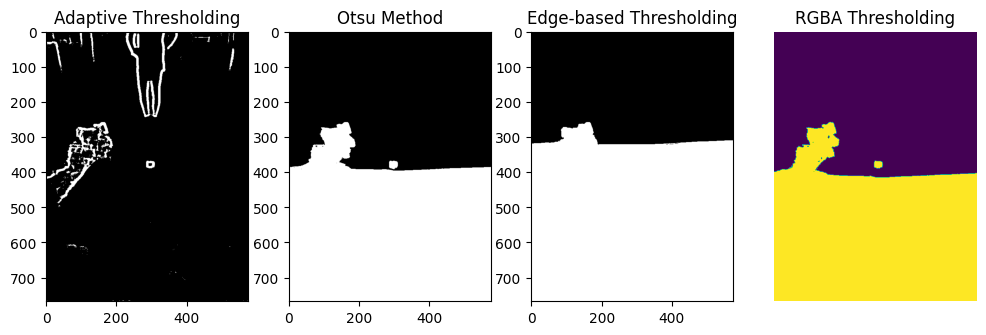

In [12]:
def convert_rgba_to_depth(rgba_img_path):
    rgba_img = cv2.imread(rgba_img_path, cv2.IMREAD_UNCHANGED)
    depth_data = np.asarray(rgba_img)[:,:,3]
    return depth_data

def adaptive_thresholding(rgba_img_path, block_size=15, C=-1):
    depth_image = convert_rgba_to_depth(rgba_img_path)
    thresh = cv2.adaptiveThreshold(depth_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)
    return thresh

def otsu_method(rgba_img_path):
    depth_image = convert_rgba_to_depth(rgba_img_path)
    _, thresh = cv2.threshold(depth_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def edge_based_thresholding(rgba_img_path):
    depth_image = convert_rgba_to_depth(rgba_img_path)
    edges = cv2.Canny(depth_image, 100, 200)
    mean = np.mean(depth_image[edges != 0])
    _, thresh = cv2.threshold(depth_image, mean, 255, cv2.THRESH_BINARY)
    return thresh

def rgba_based_thresholding(rgba_img_path, threshold_value=127):
    img = cv2.imread(rgba_img_path, cv2.IMREAD_UNCHANGED)
    alpha_channel = img[:,:,3]
    thresholded_alpha = cv2.threshold(alpha_channel, threshold_value, 255, cv2.THRESH_BINARY)[1]
    return thresholded_alpha

image1 = adaptive_thresholding(rgba_img_path="data/test-rgbd/ground_truth.png", block_size=15, C=-1)
image2 = otsu_method(rgba_img_path="data/test-rgbd/ground_truth.png")
image3 = edge_based_thresholding(rgba_img_path="data/test-rgbd/ground_truth.png")
image4 = rgba_based_thresholding(rgba_img_path="data/test-rgbd/ground_truth.png")

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title('Adaptive Thresholding')
ax[1].imshow(image2, cmap='gray')
ax[1].set_title('Otsu Method')
ax[2].imshow(image3, cmap='gray')
ax[2].set_title('Edge-based Thresholding')
ax[3].imshow(image4)
ax[3].set_title('RGBA Thresholding')
plt.axis('off')
plt.axis('off')
plt.axis('off')
plt.axis('off')
plt.show()

Adaptive thresholding works by calculating a threshold value for each pixel based on the mean or Gaussian-weighted sum of the pixels in its local neighborhood. This means that it adapts to the local variations in the image, making it suitable for images with varying illumination and contrast, such as depth images.

In contrast, the Otsu method finds a threshold value that minimizes the intra-class variance of the image, assuming a bi-modal histogram. It may not work well for images with complex histograms, such as depth images, where the foreground and background may not be clearly separated.

Edge-based thresholding uses the Canny edge detector to find the edges in the image, and then sets a threshold based on the mean intensity of the pixels on those edges. However, this method may not work well if the edges are not well-defined, or if there is significant noise in the image.

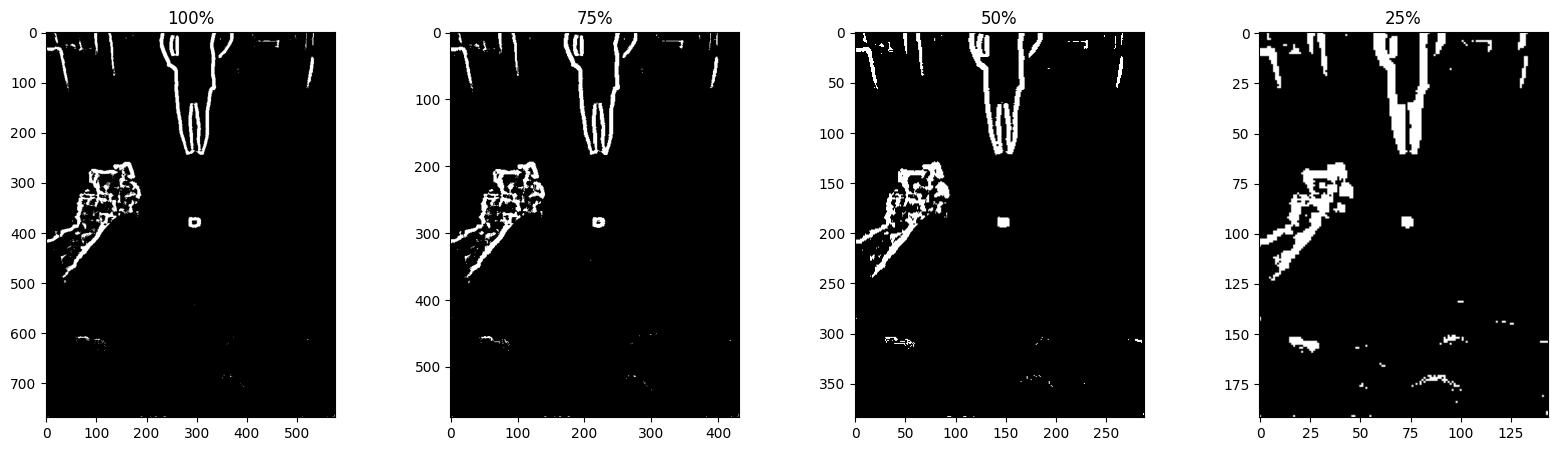

In [15]:
# Apply different thresholding techniques to different sized images
image1 = adaptive_thresholding(rgba_img_path="data/test-rgbd/ground_truth.png", block_size=15, C=-1)
image2 = adaptive_thresholding(rgba_img_path="data/test-rgbd-sizes/ground_truth_75.png", block_size=13, C=-1)
image3 = adaptive_thresholding(rgba_img_path="data/test-rgbd-sizes/ground_truth_50.png", block_size=11, C=-1)
image4 = adaptive_thresholding(rgba_img_path="data/test-rgbd-sizes/ground_truth_25.png", block_size=9, C=-1)

# Plot results
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title('100%')
ax[1].imshow(image2, cmap='gray')
ax[1].set_title('75%')
ax[2].imshow(image3, cmap='gray')
ax[2].set_title('50%')
ax[3].imshow(image4, cmap='gray')
ax[3].set_title('25%')
plt.show()

## Obstacle Detection Algorithm

The (naive) algorithm uses depth information to detect obstacles in front of a bike. It focuses on the top half of the image and applies thresholding and morphological operations to remove noise and fill gaps. It finds contours in the region of interest and checks their height against an obstacle threshold. If the height exceeds the threshold, the algorithm considers it an obstacle. The output is an image with obstacles marked and a Boolean indicating whether an obstacle was detected.

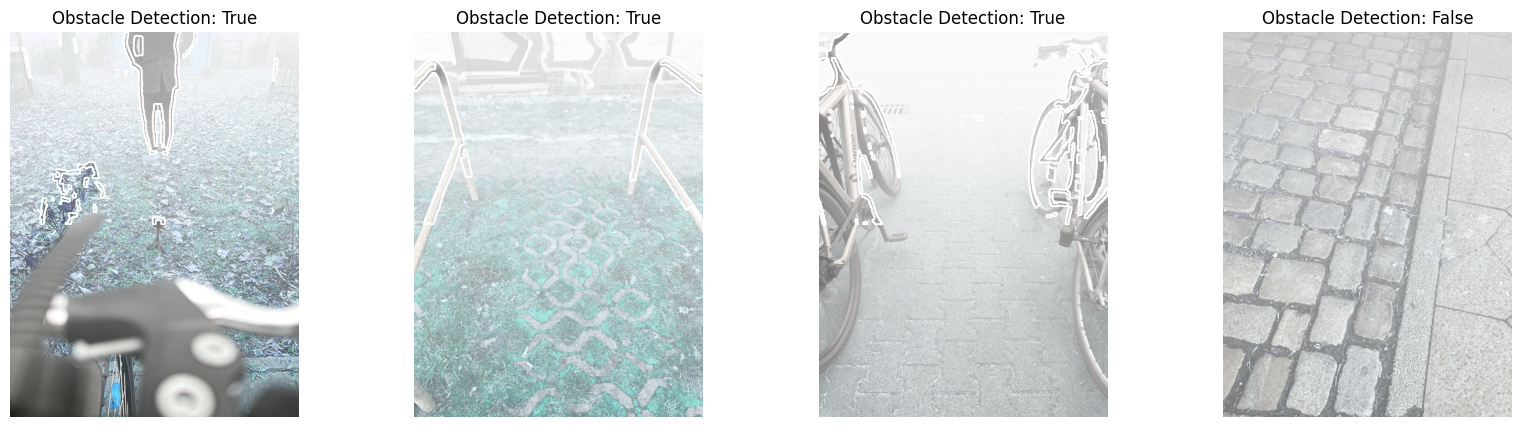

In [57]:
def detect_obstacle(rgba_img_path, obstacle_height_threshold):
    image = cv2.imread(rgba_img_path, cv2.IMREAD_UNCHANGED)
    thresh = adaptive_thresholding(rgba_img_path=rgba_img_path, block_size=15, C=-1)
    roi = thresh[:image.shape[0]//2, :]

    # Apply morphological operations to remove noise and fill gaps
    kernel = np.ones((5, 5), np.uint8)
    roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)
    roi = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)

    # Find contours in ROI
    contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (255, 255, 255), 2)

    # Loop over contours and check for obstacle
    obstacle_detected = False
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > obstacle_height_threshold:
            obstacle_detected = True
            break
    return image, obstacle_detected

# Apply different thresholding techniques
image1, result1  = detect_obstacle(rgba_img_path="data/test-rgbd/ground_truth.png", obstacle_height_threshold=70)
image2, result2  = detect_obstacle(rgba_img_path="data/test-rgbd/side_obstacle1.png", obstacle_height_threshold=70)
image3, result3  = detect_obstacle(rgba_img_path="data/test-rgbd/side_obstacle2.png", obstacle_height_threshold=70)
image4, result4  = detect_obstacle(rgba_img_path="data/test-rgbd/no_obstacle.png", obstacle_height_threshold=40)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title(f"Obstacle Detection: {result1}")
ax[1].imshow(image2, cmap='gray')
ax[1].set_title(f"Obstacle Detection: {result2}")
ax[2].imshow(image3, cmap='gray')
ax[2].set_title(f"Obstacle Detection: {result3}")
ax[3].imshow(image4, cmap='gray')
ax[3].set_title(f"Obstacle Detection: {result4}")
for ax in ax.flat:
    ax.axis('off')
plt.show()

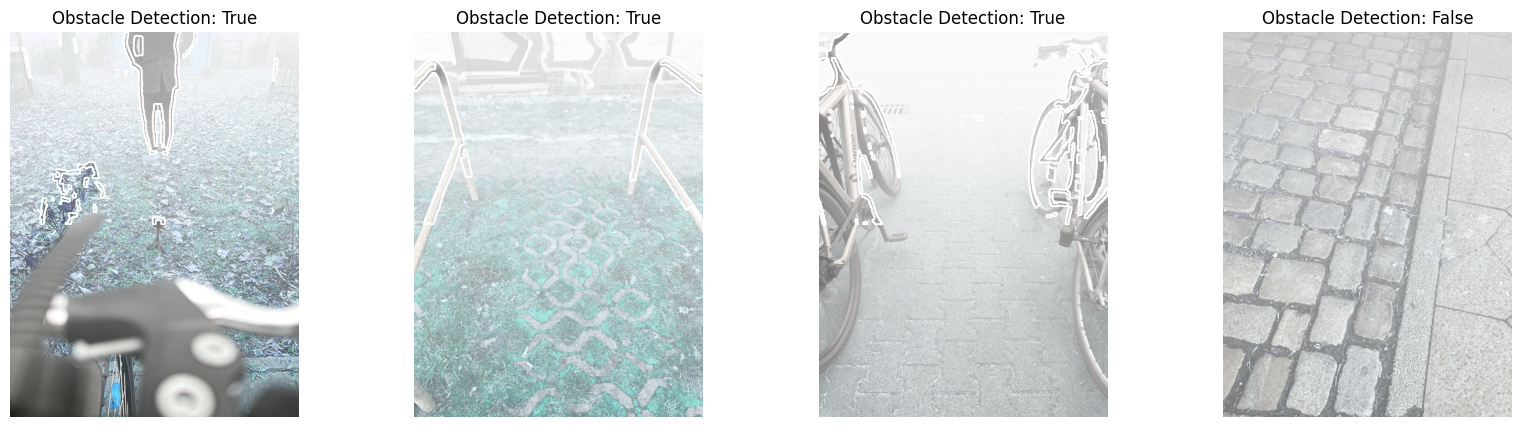

In [17]:
def detect_obstacle_v2(rgba_img_path, obstacle_height_threshold):
    image = cv2.imread(rgba_img_path, cv2.IMREAD_UNCHANGED)
    thresh = adaptive_thresholding(rgba_img_path=rgba_img_path, block_size=15, C=-1)
    roi = thresh[:image.shape[0]//2, :]

    # Apply morphological operations to remove noise and fill gaps
    kernel = np.ones((5, 5), np.uint8)
    roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, kernel)
    roi = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)

    # Find contours in ROI
    contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (255, 255, 255), 2)

    # Loop over contours and check for obstacle
    obstacle_detected = False
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if y < image.shape[0]//2 and h > obstacle_height_threshold:
            obstacle_detected = True
            break
    return image, obstacle_detected

# Apply different thresholding techniques
image1, result1  = detect_obstacle_v2(rgba_img_path="data/test-rgbd/ground_truth.png", obstacle_height_threshold=50)
image2, result2  = detect_obstacle_v2(rgba_img_path="data/test-rgbd/side_obstacle1.png", obstacle_height_threshold=50)
image3, result3  = detect_obstacle_v2(rgba_img_path="data/test-rgbd/side_obstacle2.png", obstacle_height_threshold=50)
image4, result4  = detect_obstacle_v2(rgba_img_path="data/test-rgbd/no_obstacle.png", obstacle_height_threshold=50)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(image1, cmap='gray')
ax[0].set_title(f"Obstacle Detection: {result1}")
ax[1].imshow(image2, cmap='gray')
ax[1].set_title(f"Obstacle Detection: {result2}")
ax[2].imshow(image3, cmap='gray')
ax[2].set_title(f"Obstacle Detection: {result3}")
ax[3].imshow(image4, cmap='gray')
ax[3].set_title(f"Obstacle Detection: {result4}")
for ax in ax.flat:
    ax.axis('off')
plt.show()

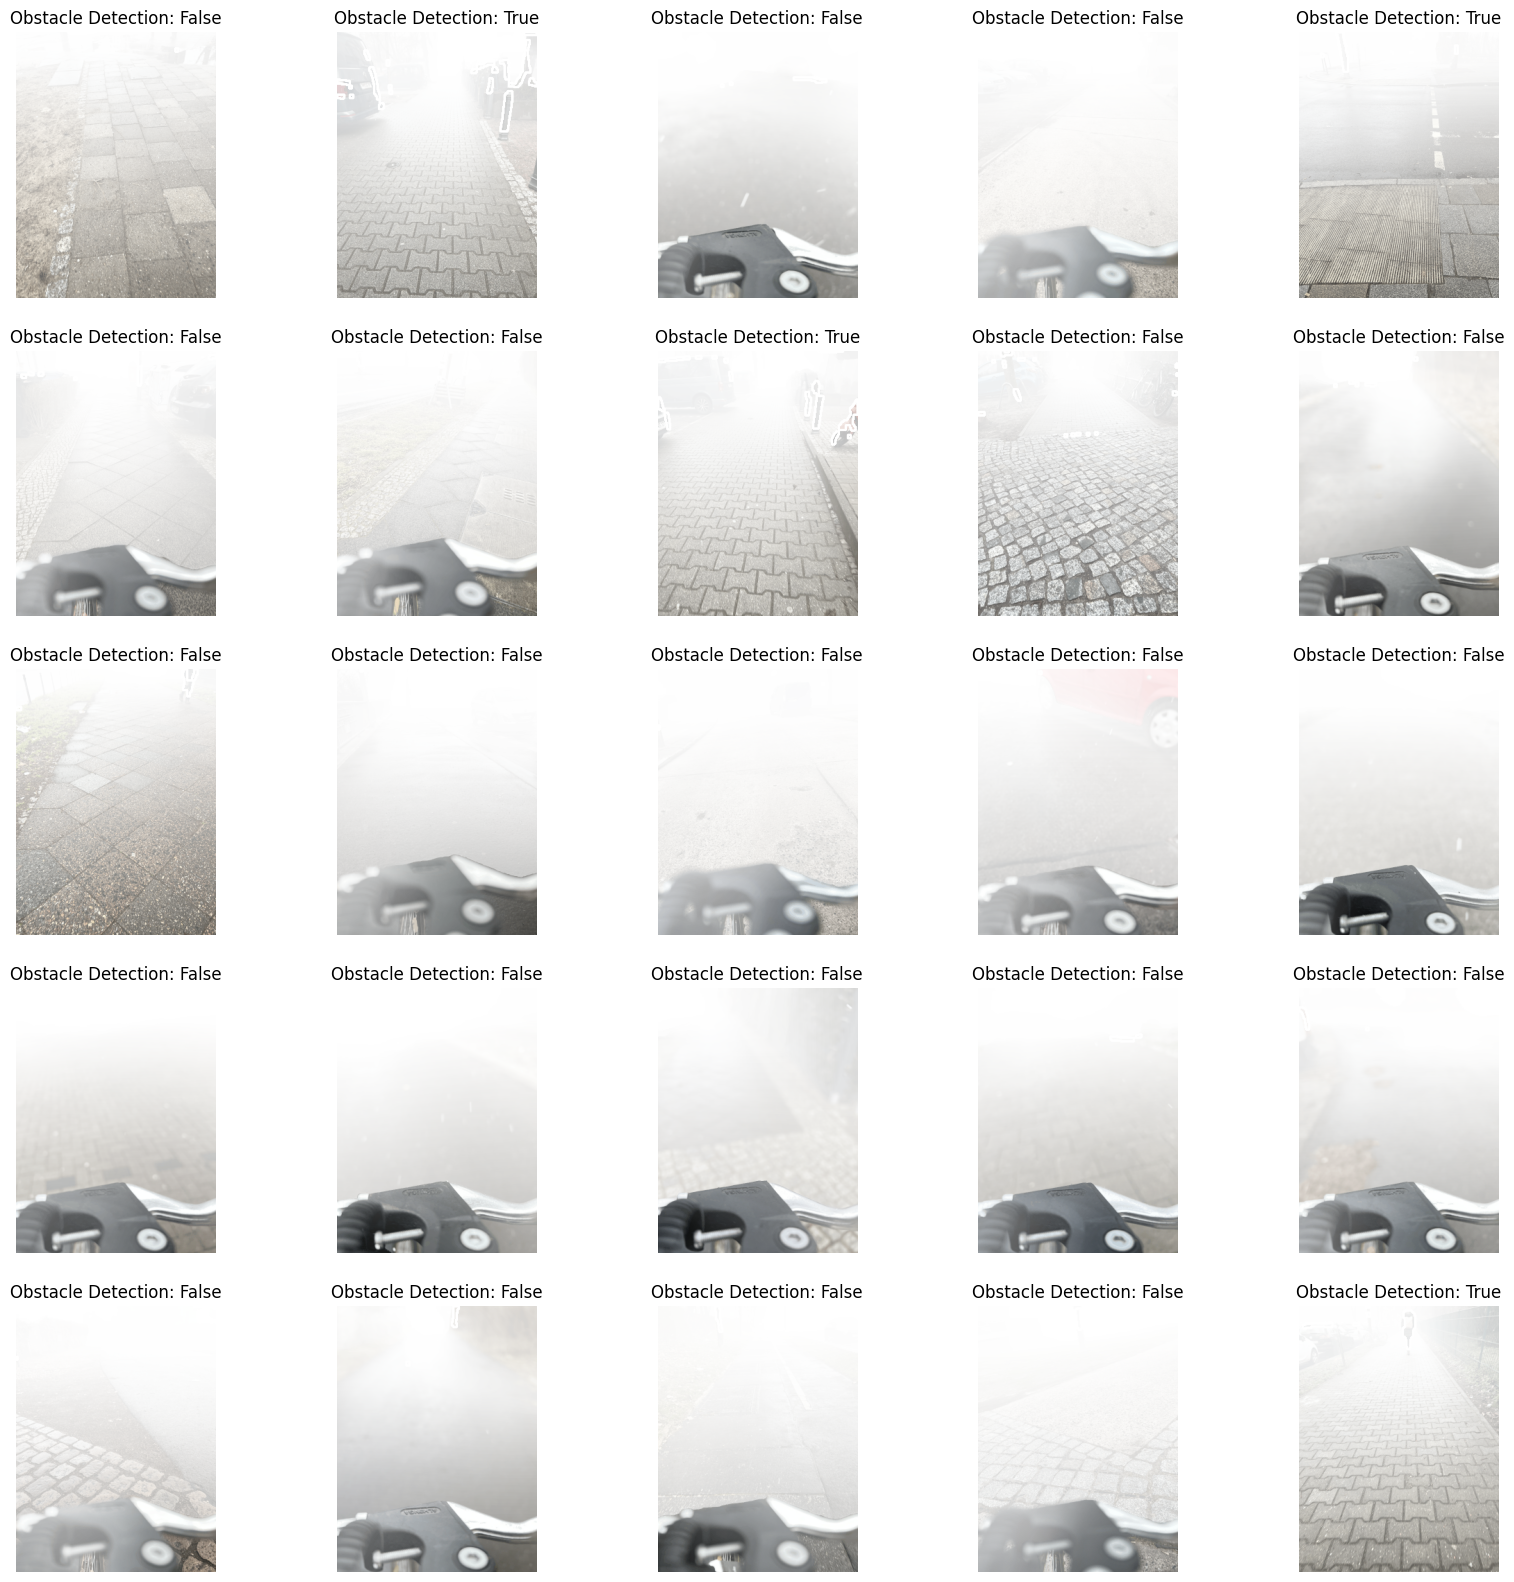

In [58]:
def detect_obstacles_using_random_selection(input_dir, obstacle_height_threshold=70):
    num_images = 25
    images = random.sample(os.listdir(input_dir), num_images)
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    for i, img in enumerate(images):
        img_path = os.path.join(input_dir, img)
        image, obstacle_detected = detect_obstacle_v2(img_path, obstacle_height_threshold)
        row = i // 5
        col = i % 5
        ax[row][col].imshow(image, cmap='gray')
        ax[row][col].set_title(os.path.splitext(img)[0])
        ax[row][col].axis('off')
        ax[row][col].set_title(f"Obstacle Detection: {obstacle_detected}")
    plt.show()

detect_obstacles_using_random_selection(
    input_dir="./data/train-rgbd/", obstacle_height_threshold=50)


In [59]:
# RGBA to NPY
def prepare_X(input_dir, output_file):
    data = []
    files = sorted(os.listdir(input_dir))
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(input_dir, file)
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
            np_image = np.array(image)
            data.append(np_image)

    np.save(output_file, np.array(data))

# 1 or 0 for Binary Classification
def prepare_y(input_dir, output_file):
    data = []
    files = sorted(os.listdir(input_dir))
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(input_dir, file)
            image, result  = detect_obstacle(rgba_img_path=file_path, obstacle_height_threshold=70)
            data.append(1 if result else 0)

    np.save(output_file, np.array(data))

# 1 or 0 for Binary Classification
def prepare_y_v2(input_dir, output_file):
    data = []
    files = sorted(os.listdir(input_dir))
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(input_dir, file)
            image, result  = detect_obstacle_v2(rgba_img_path=file_path, obstacle_height_threshold=50)
            data.append(1 if result else 0)

    np.save(output_file, np.array(data))

# 1 or 0 for Binary Classification
def prepare_y_v3(input_dir, output_file):
    data = []
    files = sorted(os.listdir(input_dir))
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(input_dir, file)
            image, result  = detect_obstacle(rgba_img_path=file_path, obstacle_height_threshold=40)
            data.append(1 if result else 0)

    np.save(output_file, np.array(data))

In [27]:
prepare_X(input_dir="data/train-rgbd", output_file="data/train_x.npy")
prepare_y(input_dir="data/train-rgbd", output_file="data/train_y.npy")
prepare_y_v2(input_dir="data/train-rgbd", output_file="data/train_y_v2.npy")


# Checking the length of the data
data_X = np.load('data/train_x.npy', allow_pickle=True)
data_y = np.load('data/train_y_v2.npy', allow_pickle=True)
data_X, data_y = len(data_X), len(data_y)

if data_X == data_y:
    print(f"Training labels are equal, length: {data_X} = {data_y}")
else:
    print("Training labels are not equal")

Training labels are equal, length: 741 = 741


In [60]:
prepare_y_v2(input_dir="data/train-rgbd", output_file="data/train_y_v2.npy")

prepare_y_v3(input_dir="data/train-rgbd", output_file="data/train_y_v3.npy")

In [30]:
prepare_X(input_dir="data/test-rgbd", output_file="data/test_x.npy")
prepare_y(input_dir="data/test-rgbd", output_file="data/test_y.npy")
prepare_y_v2(input_dir="data/test-rgbd", output_file="data/test_y_v2.npy")

# Checking the length of the data
data_X = np.load('data/test_x.npy', allow_pickle=True)
data_y = np.load('data/test_y_v2.npy', allow_pickle=True)
data_X, data_y = len(data_X), len(data_y)

if data_X == data_y:
    print(f"Test labels are equal, length: {data_X} = {data_y}")
else:
    print("Test labels are not equal")

Test labels are equal, length: 4 = 4


In [68]:
data_y = np.load('data/test_y_v2.npy', allow_pickle=True)
print(f"{data_y}")

[1 0 1 1]


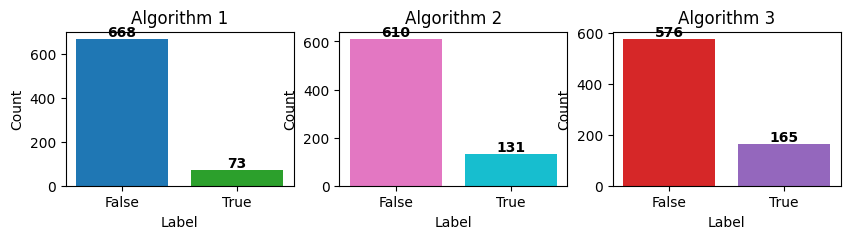

In [66]:
# load the numpy arrays of labels
labels = np.load('data/train_y.npy')
labels2 = np.load('data/train_y_v2.npy')
labels3 = np.load('data/train_y_v3.npy')

# count the number of True and False values in each array
num_true = np.count_nonzero(labels == True)
num_false = np.count_nonzero(labels == False)
num_true2 = np.count_nonzero(labels2 == True)
num_false2 = np.count_nonzero(labels2 == False)
num_true3 = np.count_nonzero(labels3 == True)
num_false3 = np.count_nonzero(labels3 == False)

# plot the results
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(10, 2))

# plot for algorithm 1
ax1.bar(['False', 'True'], [num_false, num_true], color=['tab:blue', 'tab:green'])
ax1.set_title('Algorithm 1')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
for i, v in enumerate([num_false, num_true]):
    ax1.text(i, v+10, str(v), ha='center', fontweight='bold')

# plot for algorithm 2
ax2.bar(['False', 'True'], [num_false2, num_true2], color=['tab:pink', 'tab:cyan'])
ax2.set_title('Algorithm 2')
ax2.set_xlabel('Label')
ax2.set_ylabel('Count')
for i, v in enumerate([num_false2, num_true2]):
    ax2.text(i, v+10, str(v), ha='center', fontweight='bold')

# plot for algorithm 3
ax3.bar(['False', 'True'], [num_false3, num_true3], color=['tab:red', 'tab:purple'])
ax3.set_title('Algorithm 3')
ax3.set_xlabel('Label')
ax3.set_ylabel('Count')
for i, v in enumerate([num_false3, num_true3]):
    ax3.text(i, v+10, str(v), ha='center', fontweight='bold')

plt.show()